In [324]:
import pandas as pd
import pycaret
import json
import shutil
import os
#from pycaret.regression import *
from pycaret.classification import *

# ML Logic

## Data Split 

In [325]:
assets_folder = "data"
pkl_file_path_raw = os.path.join(assets_folder, "df_dtype_converted.pkl")
df_dtype_converted = pd.read_pickle(pkl_file_path_raw)

data = df_dtype_converted.sample(frac=0.95,random_state=123) # 95% data for Model training and testing
evaluation_data = df_dtype_converted.drop(data.index) # 5% data for Final Evaluation


In [326]:
ml_model_report_inputs = {}

In [327]:
# Split Train/Test (70% Train, 30% Test)
train_size = int(0.70 * len(data))  
train_data = data[:train_size]  # First 70% as Train
test_data = data[train_size:]   # Remaining 30% as Test

ml_model_report_inputs['data_split'] = {
    'train_data_size' : len(train_data),
    'test_data_size' : len(test_data),
    'evaluation_data_size' : len(evaluation_data)
}

## User Inputs

In [328]:
assets_folder = "metadata"

json_file_path_user_ip = os.path.join(assets_folder, "user_inputs.json")
with open(json_file_path_user_ip, 'r') as f:
    user_inputs = json.load(f)
    
json_file_path_user_dtype = os.path.join(assets_folder, "user_data_types.json")
with open(json_file_path_user_dtype, 'r') as f:
    user_data_types = json.load(f)

## Preprocessing by Logic

In [329]:
assets_folder = "metadata"
json_file_path_prepocess_ip = os.path.join(assets_folder, "preprocessing_inputs.json") 
with open(json_file_path_prepocess_ip, 'r') as f:
    preprocessing_inputs = json.load(f)

In [330]:
preprocessing_inputs

{'transformation_req': True,
 'normalization_req': True,
 'imput_method': 'mean',
 'outliers_req': False,
 'feature_sele_req': False,
 'multicollinearity_req': False,
 'target_imbalance_req': False,
 'transform_target_req': None}

### User Inputs or Fixed Parameters

In [331]:
# dataFrame Input
# data = df_dtype_converted 

#Target 
target = user_inputs['Target Column']

#remove Features
if user_inputs['Remove Features'] == 'None':
    ignore_features = False
else:
    ignore_features = user_inputs['Remove Features']
    
#Ordinal Features    
ordinal_features = {}
for key, value in user_inputs['Data Types'].items():
    if (value == 'Categorical(Ordinal)') & (len(user_inputs['Ordinal Degree']) != 0):
        ordinal_features  = {key : user_inputs['Ordinal Degree']}
        break
    else:
        ordinal_features = None
    
#bin Numerical features    
if user_inputs['Binning Columns'] == 'None':
    bin_numeric_features = False
else:
    bin_numeric_features = user_inputs['Binning Columns']

#train size    
train_size = int(user_inputs['Training Data Size'].strip('%'))/100  # int(train_size.strip('%'))/100

#Number of K-Flod
fold = int(user_inputs['K-Fold'])

#Numerical Imputation Method
numeric_imputation = preprocessing_inputs['imput_method']


### Combinations of all the Parameters defined by Logic

In [332]:
import itertools

# Assume these booleans come from your GUI
# (If the user requested normalization, transformation, etc.)


# For transformation: if requested, test both on and off
if preprocessing_inputs['transformation_req']:
    # Each tuple: (apply transformation, method)
    transformation_options = [(True, 'yeo-johnson'), (True, 'quantile'), (False, None)]
else:
    transformation_options = [(False, None)]

# For normalization: even if requested, include the off option
if preprocessing_inputs['normalization_req']:
    normalization_options = [(True, 'zscore'), (True, 'minmax'), (True, 'maxabs'), (True, 'robust'), (False, None)]
else:
    normalization_options = [(False, None)]

# For outlier detection: include an option to not remove outliers
if preprocessing_inputs['outliers_req']:
    outlier_options = [(True, 'iforest'), (True, 'ee'), (True, 'lof'), (False, None)]
else:
    outlier_options = [(False, None)]

# For multicollinearity, target transformation, and feature selection, these are simple flags.
if preprocessing_inputs['multicollinearity_req']:
    multicollinearity_options = [True, False]
else:
    multicollinearity_options = [False]

if preprocessing_inputs['target_imbalance_req']:
    target_transformation_options = [True, False]
else:
    target_transformation_options = [False]

if preprocessing_inputs['feature_sele_req']:
    feature_selection_options = [True, False]
else:
    feature_selection_options = [False]

# Build the grid (each combination is a list of 6 items)
combinations = [list(combo) for combo in itertools.product(
    transformation_options,    # combo[0]: (transformation, method)
    normalization_options,     # combo[1]: (normalize, method)
    outlier_options,           # combo[2]: (remove_outliers, method)
    multicollinearity_options, # combo[3]: flag
    target_transformation_options,  # combo[4]: flag
    feature_selection_options  # combo[5]: flag
)]

# Print grid for verification
for combo in combinations:
    trans_option, norm_option, out_option, multi_option, target_trans_option, feat_select_option = combo
    print("Combination:")
    print(f"  Transformation: {trans_option[0]}, Method: {trans_option[1]}")
    print(f"  Normalization: {norm_option[0]}, Method: {norm_option[1]}")
    print(f"  Outlier Removal: {out_option[0]}, Method: {out_option[1]}")
    print(f"  Multicollinearity: {multi_option}")
    print(f"  Target Imbalance: {target_trans_option}")
    print(f"  Feature Selection: {feat_select_option}")
    print("-" * 40)


Combination:
  Transformation: True, Method: yeo-johnson
  Normalization: True, Method: zscore
  Outlier Removal: False, Method: None
  Multicollinearity: False
  Target Imbalance: False
  Feature Selection: False
----------------------------------------
Combination:
  Transformation: True, Method: yeo-johnson
  Normalization: True, Method: minmax
  Outlier Removal: False, Method: None
  Multicollinearity: False
  Target Imbalance: False
  Feature Selection: False
----------------------------------------
Combination:
  Transformation: True, Method: yeo-johnson
  Normalization: True, Method: maxabs
  Outlier Removal: False, Method: None
  Multicollinearity: False
  Target Imbalance: False
  Feature Selection: False
----------------------------------------
Combination:
  Transformation: True, Method: yeo-johnson
  Normalization: True, Method: robust
  Outlier Removal: False, Method: None
  Multicollinearity: False
  Target Imbalance: False
  Feature Selection: False
---------------------

In [333]:
print(f'Total Preprocessing Combinations Created: {len(combinations)}')

Total Preprocessing Combinations Created: 15


In [334]:
ml_model_report_inputs['total_preprocess_param_comb'] = len(combinations)

### Intial Run to identify top ML models

### Identify top 3 Models to apply preprocessing parameter combinations

In [335]:
#from pycaret.regression import *

class_intital = setup(data = data,
            target= target,
            fold= fold,
            ignore_features= ignore_features,
            bin_numeric_features=bin_numeric_features,
            train_size=train_size,
            numeric_imputation = numeric_imputation,
            ordinal_features= ordinal_features,
            session_id= 123)

compare_models(include=['lr','ridge','svm','knn','dt','rf','ada','gbc'],sort = 'auc')
class_initial_compare = pull()
class_initial_compare.head()
Top_Models_initial = list(class_initial_compare.index[:3])
print(f'Top 3 Models by {fold} KFlod based in top AUC are {Top_Models_initial}')

,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7549,0.8194,0.5221,0.6973,0.5962,0.4259,0.4354,0.1740
lr,Logistic Regression,0.7686,0.8186,0.5556,0.7160,0.6245,0.4615,0.4699,0.5500
gbc,Gradient Boosting Classifier,0.7490,0.8131,0.5841,0.6554,0.6158,0.4310,0.4338,0.0160
rf,Random Forest Classifier,0.7412,0.7993,0.5619,0.6498,0.5996,0.4108,0.4152,0.0300
ada,Ada Boost Classifier,0.7431,0.7732,0.5783,0.6465,0.6098,0.4194,0.4212,0.0120
knn,K Neighbors Classifier,0.6922,0.6995,0.4943,0.5672,0.5277,0.3012,0.3030,0.0120
dt,Decision Tree Classifier,0.6882,0.6668,0.5956,0.5486,0.5704,0.3266,0.3279,0.1500
svm,SVM - Linear Kernel,0.5725,0.5287,0.3930,0.3094,0.2769,0.0623,0.0702,0.1640


Top 3 Models by 5 KFlod based in top AUC are ['ridge', 'lr', 'gbc']


In [336]:
list(class_initial_compare['Prec.'])

[0.6973, 0.716, 0.6554, 0.6498, 0.6465, 0.5672, 0.5486, 0.3094]

In [337]:
intial_models_comparison = {
    "model" : list(class_initial_compare['Model']),
    "accuracy" : list(class_initial_compare['Accuracy']),
    "auc" : list(class_initial_compare['AUC']),
    "recall" : list(class_initial_compare['Recall']),
    "precision" : list(class_initial_compare['Prec.']),
    "f1": list(class_initial_compare['F1']),
}

ml_model_report_inputs['intial_models_comparison'] = intial_models_comparison

## Preprocessing Parameters Tuning

In [338]:
model_best_comp = []
model_acc = []
model_auc = []
model_recal = []
model_prec = []
model_f1 = []
params = []

for i in range(len(combinations)):
    logic_data = combinations[i]
    trans_option = logic_data[0]  # tuple: (transformation flag, transformation_method)
    norm_option  = logic_data[1]  # tuple: (normalize flag, normalize_method)
    out_option   = logic_data[2]  # tuple: (remove_outliers flag, outliers_method)
    multi_option = logic_data[3]  # flag
    target_imbalance = logic_data[4]  # flag
    feat_select_option = logic_data[5]  # flag

    try:
        reg = setup(
            data=data,
            target=target,
            fold=fold,
            ignore_features=ignore_features,
            bin_numeric_features=bin_numeric_features,
            train_size=train_size,
            numeric_imputation=numeric_imputation,
            ordinal_features=ordinal_features,
            normalize = norm_option[0],             # use grid value
            normalize_method = norm_option[1],
            transformation = trans_option[0],         # use grid value
            transformation_method = trans_option[1],
            remove_outliers = out_option[0],          # use grid value
            outliers_method = out_option[1],
            remove_multicollinearity = multi_option,
            fix_imbalance = target_imbalance,
            feature_selection = feat_select_option,
            session_id = 123
        )
        best_model = compare_models(
            include=Top_Models_initial,
            sort='auc'
        )
        result_int = pull()
        model_best_comp.append(result_int.iloc[0]['Model'])
        model_acc.append(result_int.iloc[0]['Accuracy'])
        model_auc.append(result_int.iloc[0]['AUC'])
        model_recal.append(result_int.iloc[0]['Recall'])
        model_prec.append(result_int.iloc[0]['Prec.'])
        model_f1.append(result_int.iloc[0]['F1'])
        params.append(combinations[i])
    except Exception as e:
        print("Error for combination", combinations[i], ":", e)
        continue

model_comparision_results = {
    'Model': model_best_comp,
    'Accuracy': model_acc,
    'AUC': model_auc,
    'Recall' : model_recal,
    'Precision' : model_prec,
    'F1' : model_f1,
    'Parameters': params
}

,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7569,0.8213,0.5332,0.7006,0.6038,0.4332,0.4427,0.0080
lr,Logistic Regression,0.7549,0.8196,0.5387,0.6910,0.6039,0.4307,0.4385,0.0080
gbc,Gradient Boosting Classifier,0.7510,0.8124,0.5898,0.6581,0.6203,0.4365,0.4391,0.0180


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7588,0.8202,0.5332,0.7039,0.6056,0.4369,0.4462,0.0080
lr,Logistic Regression,0.7549,0.8163,0.4884,0.7176,0.5797,0.4161,0.4320,0.0360
gbc,Gradient Boosting Classifier,0.7510,0.8124,0.5898,0.6581,0.6203,0.4365,0.4391,0.0200


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7784,0.8245,0.5332,0.7635,0.6251,0.4752,0.4922,0.0060
lr,Logistic Regression,0.7686,0.8224,0.4717,0.7860,0.5869,0.4397,0.4690,0.0080
gbc,Gradient Boosting Classifier,0.7510,0.8124,0.5898,0.6581,0.6203,0.4365,0.4391,0.0180


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7569,0.8217,0.5332,0.7006,0.6038,0.4332,0.4427,0.0080
lr,Logistic Regression,0.7569,0.8205,0.5387,0.6963,0.6058,0.4344,0.4428,0.0080
gbc,Gradient Boosting Classifier,0.7510,0.8124,0.5898,0.6581,0.6203,0.4365,0.4391,0.0200


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7745,0.8246,0.5498,0.7433,0.6279,0.4717,0.4854,0.0080
lr,Logistic Regression,0.7588,0.8190,0.5554,0.6937,0.6138,0.4422,0.4499,0.0100
gbc,Gradient Boosting Classifier,0.7510,0.8124,0.5898,0.6581,0.6203,0.4365,0.4391,0.0200


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7608,0.8206,0.5219,0.7207,0.6019,0.4375,0.4511,0.0120
lr,Logistic Regression,0.7647,0.8189,0.5498,0.7140,0.6185,0.4528,0.4625,0.0100
gbc,Gradient Boosting Classifier,0.7490,0.8133,0.5841,0.6554,0.6158,0.4310,0.4338,0.0180


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7647,0.8206,0.4938,0.7474,0.5930,0.4373,0.4568,0.0080
gbc,Gradient Boosting Classifier,0.7490,0.8133,0.5841,0.6554,0.6158,0.4310,0.4338,0.0220
lr,Logistic Regression,0.7510,0.8108,0.3933,0.7900,0.5241,0.3802,0.4232,0.0080


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7608,0.8200,0.5163,0.7245,0.5999,0.4362,0.4508,0.0080
lr,Logistic Regression,0.7647,0.8169,0.4995,0.7425,0.5959,0.4390,0.4569,0.0080
gbc,Gradient Boosting Classifier,0.7490,0.8133,0.5841,0.6554,0.6158,0.4310,0.4338,0.0220


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7608,0.8205,0.5219,0.7207,0.6019,0.4375,0.4511,0.0100
lr,Logistic Regression,0.7627,0.8192,0.5443,0.7117,0.6138,0.4473,0.4575,0.0080
gbc,Gradient Boosting Classifier,0.7490,0.8133,0.5841,0.6554,0.6158,0.4310,0.4338,0.0200


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7608,0.8203,0.5219,0.7207,0.6019,0.4375,0.4511,0.0100
lr,Logistic Regression,0.7608,0.8190,0.5443,0.7042,0.6119,0.4435,0.4523,0.0080
gbc,Gradient Boosting Classifier,0.7490,0.8133,0.5841,0.6554,0.6158,0.4310,0.4338,0.0200


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7569,0.8194,0.5276,0.6999,0.6008,0.4313,0.4405,0.0060
lr,Logistic Regression,0.7667,0.8192,0.5443,0.7168,0.6179,0.4548,0.4641,0.0060
gbc,Gradient Boosting Classifier,0.7510,0.8130,0.5897,0.6570,0.6193,0.4358,0.4388,0.0200


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7510,0.8202,0.4995,0.6988,0.5821,0.4120,0.4239,0.0060
lr,Logistic Regression,0.7471,0.8172,0.4546,0.7170,0.5554,0.3911,0.4114,0.0060
gbc,Gradient Boosting Classifier,0.7490,0.8132,0.5841,0.6554,0.6158,0.4310,0.4338,0.0200


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7510,0.8205,0.4995,0.6988,0.5821,0.4120,0.4239,0.0060
lr,Logistic Regression,0.7529,0.8183,0.4546,0.7348,0.5608,0.4024,0.4251,0.0060
gbc,Gradient Boosting Classifier,0.7490,0.8136,0.5841,0.6554,0.6158,0.4310,0.4338,0.0160


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7569,0.8194,0.5276,0.6999,0.6008,0.4313,0.4405,0.0120
lr,Logistic Regression,0.7667,0.8190,0.5443,0.7168,0.6179,0.4548,0.4641,0.0060
gbc,Gradient Boosting Classifier,0.7490,0.8123,0.5841,0.6554,0.6158,0.4310,0.4338,0.0200


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7549,0.8194,0.5221,0.6973,0.5962,0.4259,0.4354,0.0060
lr,Logistic Regression,0.7686,0.8186,0.5556,0.7160,0.6245,0.4615,0.4699,0.0080
gbc,Gradient Boosting Classifier,0.7490,0.8131,0.5841,0.6554,0.6158,0.4310,0.4338,0.0200


Transformation: True, Method: yeo-johnson
  Normalization: True, Method: zscore
  Outlier Removal: True, Method: ee
  Multicollinearity: False
  Target Transformation: True
  Feature Selection: False

In [339]:
Final_model_comp = pd.DataFrame(model_comparision_results).sort_values(by = 'AUC', ascending = False)
Final_model_comp

,Model,Accuracy,AUC,Recall,Precision,F1,Parameters
4,Ridge Classifier,0.7745,0.8246,0.5498,0.7433,0.6279,"[(True, yeo-johnson), (False, None), (False, N..."
2,Ridge Classifier,0.7784,0.8245,0.5332,0.7635,0.6251,"[(True, yeo-johnson), (True, maxabs), (False, ..."
3,Ridge Classifier,0.7569,0.8217,0.5332,0.7006,0.6038,"[(True, yeo-johnson), (True, robust), (False, ..."
0,Ridge Classifier,0.7569,0.8213,0.5332,0.7006,0.6038,"[(True, yeo-johnson), (True, zscore), (False, ..."
5,Ridge Classifier,0.7608,0.8206,0.5219,0.7207,0.6019,"[(True, quantile), (True, zscore), (False, Non..."
6,Ridge Classifier,0.7647,0.8206,0.4938,0.7474,0.5930,"[(True, quantile), (True, minmax), (False, Non..."
8,Ridge Classifier,0.7608,0.8205,0.5219,0.7207,0.6019,"[(True, quantile), (True, robust), (False, Non..."
12,Ridge Classifier,0.7510,0.8205,0.4995,0.6988,0.5821,"[(False, None), (True, maxabs), (False, None),..."
9,Ridge Classifier,0.7608,0.8203,0.5219,0.7207,0.6019,"[(True, quantile), (False, None), (False, None..."
1,Ridge Classifier,0.7588,0.8202,0.5332,0.7039,0.6056,"[(True, yeo-johnson), (True, minmax), (False, ..."


In [340]:
Final_model_comp = pd.DataFrame(model_comparision_results).sort_values(by = 'AUC', ascending = False)
Final_model_comp.head()
print(f'Top Models Fitted for Preprocessing : {Final_model_comp.shape[0]}')
print(f'Top Model : {Final_model_comp.iloc[0,0]} Accuracy : {Final_model_comp.iloc[0,1]} AUC : {Final_model_comp.iloc[0,2]}')
print(f'Preprocessing Parameters: \n Transformation: : {Final_model_comp.iloc[0,6][0][0]}, Method : {Final_model_comp.iloc[0,6][0][1]} \n Normalization: {Final_model_comp.iloc[0,6][1][0]} , Method : {Final_model_comp.iloc[0,6][1][1]} \n Outlier: {Final_model_comp.iloc[0,6][2][0]}, Method : {Final_model_comp.iloc[0,6][2][1]} \n Multicollinearity:{Final_model_comp.iloc[0,6][3]} \n Target Imbalance: {Final_model_comp.iloc[0,6][4]} \n Feature Selection : {Final_model_comp.iloc[0,6][5]}  ')

Top Models Fitted for Preprocessing : 15
Top Model : Ridge Classifier Accuracy : 0.7745 AUC : 0.8246
Preprocessing Parameters: 
 Transformation: : True, Method : yeo-johnson 
 Normalization: False , Method : None 
 Outlier: False, Method : None 
 Multicollinearity:False 
 Target Imbalance: False 
 Feature Selection : False  


In [341]:
model_comparison_results = {
    "total_fits": Final_model_comp.shape[0],  # Total models evaluated
    "top_model": Final_model_comp['Model'][0],  # Best performing model
    "top_param": {
        "Transformation": Final_model_comp.iloc[0, 6][0][0],
        "Transform_Method": Final_model_comp.iloc[0, 6][0][1],
        "Normalization": Final_model_comp.iloc[0, 6][1][0],
        "Normalize_Method": Final_model_comp.iloc[0, 6][1][1],
        "Outlier": Final_model_comp.iloc[0, 6][2][0],
        "Outlier_Method": Final_model_comp.iloc[0, 6][2][1],
        "Multicollinearity": Final_model_comp.iloc[0, 6][3],
        "Target Transformation": Final_model_comp.iloc[0, 6][4],
        "Feature Selection": Final_model_comp.iloc[0, 6][5]
    },  # Properly closed "top_param"
    "top_acc": Final_model_comp.iloc[0,1],  # Best R² score
    "top_auc": Final_model_comp.iloc[0,2],
    "top_recall" : Final_model_comp.iloc[0,3],
    "top_prec" : Final_model_comp.iloc[0,4],
    "top_f1" : Final_model_comp.iloc[0,5]
}

ml_model_report_inputs['model_comparison'] = model_comparison_results


In [342]:
model_comparison_results

{'total_fits': 15,
 'top_model': 'Ridge Classifier',
 'top_param': {'Transformation': True,
  'Transform_Method': 'yeo-johnson',
  'Normalization': False,
  'Normalize_Method': None,
  'Outlier': False,
  'Outlier_Method': None,
  'Multicollinearity': False,
  'Target Transformation': False,
  'Feature Selection': False},
 'top_acc': 0.7745,
 'top_auc': 0.8246,
 'top_recall': 0.5498,
 'top_prec': 0.7433,
 'top_f1': 0.6279}

In [343]:
# ['lr','ridge','svm','knn','dt','rf','ada','gbc']
models_dic = {
    'Gradient Boosting Classifier' : 'gbc',
    'Random Forest Classifier' : 'rf',
    'Ada Boost Classifier' : 'ada',
    'Ridge Classifier' : 'ridge',
    'Logistic Regression' : 'lr',
    'Decision Tree Classifier' : 'dt',
    'K Neighbors Classifier' : 'knn',
    'SVM - Linear Kernel' : 'svm'
}

## Create Best Model from Preprocessing Parameter Tunning

In [344]:

best_ml = models_dic[Final_model_comp.iloc[0,0]]
best_param = Final_model_comp.iloc[0,6]
best_model_final_setup = setup(
            data=data,
            target=target,
            fold=fold,
            ignore_features=ignore_features,
            bin_numeric_features=bin_numeric_features,
            train_size=train_size,
            numeric_imputation=numeric_imputation,
            ordinal_features=ordinal_features,
            normalize = best_param[1][0],             # use grid value
            normalize_method = best_param[1][1],
            transformation = best_param[0][0],         # use grid value
            transformation_method = best_param[0][1],
            remove_outliers = best_param[2][0],          # use grid value
            outliers_method = best_param[2][1],
            remove_multicollinearity = best_param[3],
            fix_imbalance = best_param[4],
            feature_selection = best_param[5],
            session_id = 123)
best_model_final = create_model(best_ml)
X_train_transformed_reg = get_config('X_train_transformed')
best_model_final_wt_preprocess = pull()
sample_reg = X_train_transformed_reg.sample(n=100)


,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7549,0.7936,0.4857,0.7083,0.5763,0.4122,0.4267
1,0.7941,0.8448,0.4857,0.8500,0.6182,0.4912,0.5273
2,0.7647,0.8064,0.5278,0.7308,0.6129,0.4501,0.4624
3,0.7941,0.8721,0.6667,0.7273,0.6957,0.5405,0.5417
4,0.7647,0.8060,0.5833,0.7000,0.6364,0.4646,0.4688
Mean,0.7745,0.8246,0.5498,0.7433,0.6279,0.4717,0.4854
Std,0.0164,0.0293,0.0685,0.0546,0.0391,0.0428,0.0428


In [345]:
best_model_final_wt_preprocess

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7549,0.7936,0.4857,0.7083,0.5763,0.4122,0.4267
1,0.7941,0.8448,0.4857,0.8500,0.6182,0.4912,0.5273
2,0.7647,0.8064,0.5278,0.7308,0.6129,0.4501,0.4624
3,0.7941,0.8721,0.6667,0.7273,0.6957,0.5405,0.5417
4,0.7647,0.8060,0.5833,0.7000,0.6364,0.4646,0.4688
Mean,0.7745,0.8246,0.5498,0.7433,0.6279,0.4717,0.4854
Std,0.0164,0.0293,0.0685,0.0546,0.0391,0.0428,0.0428


In [346]:
best_model_final_results = {
    'preprocess_results' : {'Accuracy' : best_model_final_wt_preprocess.loc['Mean','Accuracy'], 
                            'AUC' : best_model_final_wt_preprocess.loc['Mean','AUC'],
                            'Recall': best_model_final_wt_preprocess.loc['Mean','Recall'],
                            'Prec' : best_model_final_wt_preprocess.loc['Mean','Prec.'],
                            'F1' : best_model_final_wt_preprocess.loc['Mean','F1'],
                            }  
}

In [347]:
pd.DataFrame(best_model_final_results)

,preprocess_results
AUC,0.8246
Accuracy,0.7745
F1,0.6279
Prec,0.7433
Recall,0.5498


## Model Evaluation

In [348]:
evaluate_model(best_model_final)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Combination:
  Transformation: True, Method: yeo-johnson
  Normalization: True, Method: zscore
  Outlier Removal: True, Method: iforest
  Multicollinearity: False
  Target Transformation: True
  Feature Selection: False

## Residual Plot

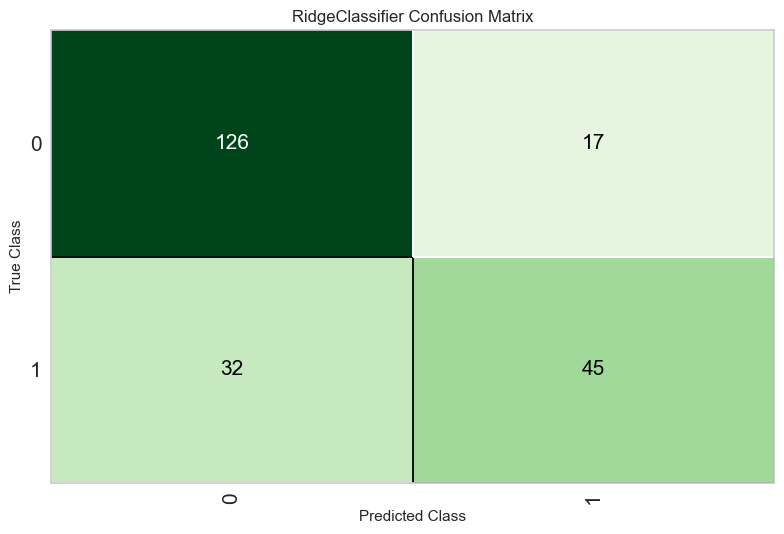

In [349]:
plot_model(best_model_final,plot = 'confusion_matrix')

## Error plot

## Feature Importance

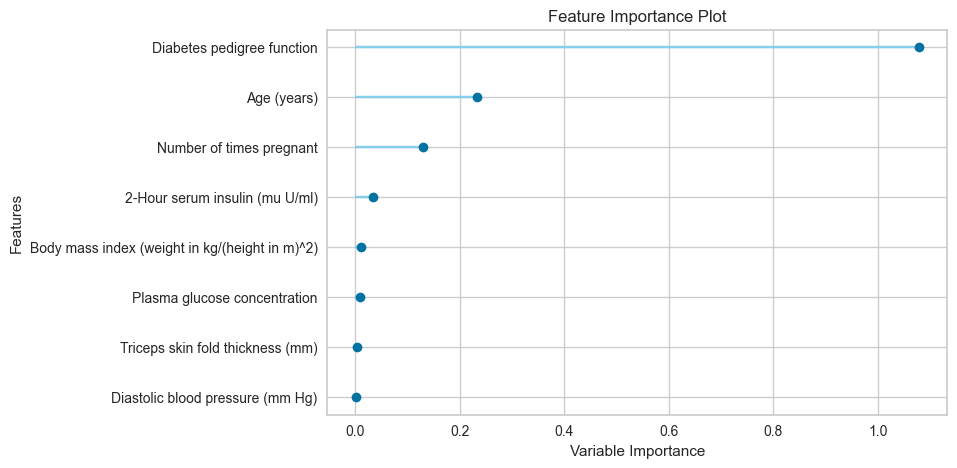

In [350]:
plot_model(best_model_final, plot = 'feature')

## Prediction

In [351]:
best_model_final_predict = predict_model(best_model_final)
best_model_final_wt_preproces_test = pull()



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.7773,0.7328,0.5844,0.7258,0.6475,0.4874,0.4936


In [352]:
best_model_final_wt_preproces_test.iloc[0,0]

'Ridge Classifier'

In [353]:
best_model_final_results['test_result'] = {'Accuracy' : best_model_final_wt_preproces_test.iloc[0,1], 
                                           'AUC' : best_model_final_wt_preproces_test.iloc[0,2],
                                           'Recall' : best_model_final_wt_preproces_test.iloc[0,3],
                                           'Prec' : best_model_final_wt_preproces_test.iloc[0,4],
                                           'F1' : best_model_final_wt_preproces_test.iloc[0,5],
                                           }

In [354]:
best_model_final_predict.head()

,Number of times pregnant,Plasma glucose concentration,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable,prediction_label
532,1,86,66,52,65,41.299999,0.917,29,0,0
477,7,114,76,17,110,23.799999,0.466,31,0,0
56,7,187,68,39,304,37.700001,0.254,41,1,1
370,3,173,82,48,465,38.400002,2.137,25,1,1
251,2,129,84,0,0,28.000000,0.284,27,0,0


In [355]:
print(best_model_final)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=123, solver='auto',
                tol=0.0001)


## Hyper Parameter Tunning

In [356]:
tune_best_model_final = tune_model(best_model_final)
best_model_final_wt_preproces_test_hyperpar = pull()
best_model_final_results['hyperpar_test_result'] = {'Accuracy' : best_model_final_wt_preproces_test_hyperpar.loc['Mean','Accuracy'], 
                                                    'AUC' : best_model_final_wt_preproces_test_hyperpar.loc['Mean','AUC'],
                                                    'Recall': best_model_final_wt_preproces_test_hyperpar.loc['Mean','Recall'],
                                                    'Prec' : best_model_final_wt_preproces_test_hyperpar.loc['Mean','Prec.'],
                                                    'F1' : best_model_final_wt_preproces_test_hyperpar.loc['Mean','F1'],
                                                    } 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7549,0.7902,0.4857,0.7083,0.5763,0.4122,0.4267
1,0.8039,0.8469,0.5143,0.8571,0.6429,0.5191,0.5513
2,0.7549,0.8102,0.5278,0.7037,0.6032,0.4311,0.4404
3,0.7941,0.8746,0.6667,0.7273,0.6957,0.5405,0.5417
4,0.7549,0.8064,0.5556,0.6897,0.6154,0.4386,0.4441
Mean,0.7725,0.8257,0.5500,0.7372,0.6267,0.4683,0.4808
Std,0.0218,0.0307,0.0625,0.0612,0.0406,0.0514,0.0540


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [357]:
type(tune_best_model_final)

sklearn.linear_model._ridge.RidgeClassifier

## Train the Model with Whole Data Set Train + Test (95%)

In [358]:
best_model_final_fit = finalize_model(tune_best_model_final)




## Test with Evaluation Data Set

In [359]:
predict_model(best_model_final_fit, data= evaluation_data)
evaluate_results = pull()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.7895,0.6923,0.3846,1.0000,0.5556,0.4513,0.5398


In [360]:
evaluate_results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.7895,0.6923,0.3846,1.0,0.5556,0.4513,0.5398


In [361]:
evaluate_results.iloc[0,1]

0.7895

In [362]:
best_model_final_results['eval_result'] = {'Accuracy' : evaluate_results.iloc[0,1], 
                                           'AUC' : evaluate_results.iloc[0,2],
                                           'Recall' : evaluate_results.iloc[0,3],
                                           'Prec' : evaluate_results.iloc[0,4],
                                           'F1' : evaluate_results.iloc[0,5],
                                           }

In [363]:
ml_model_report_inputs['best_model_final_results']= best_model_final_results

In [364]:
ml_model_eval = []
ml_model_eval_acc = []
ml_model_eval_auc = []
ml_model_eval_recall = []
ml_model_eval_prec = []
ml_model_eval_f1 = []
class_final_eval = pull()
ml_model_eval.append(class_final_eval.iloc[0,0])
ml_model_eval_acc.append(class_final_eval.iloc[0,1])
ml_model_eval_auc.append(class_final_eval.iloc[0,2])
ml_model_eval_recall.append(class_final_eval.iloc[0,3])
ml_model_eval_prec.append(class_final_eval.iloc[0,4])
ml_model_eval_f1.append(class_final_eval.iloc[0,5])

In [365]:
class_final_eval

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.7895,0.6923,0.3846,1.0,0.5556,0.4513,0.5398


## Ensemble Modeling

In [366]:
ensemble_bag = ensemble_model(best_model_final , method = 'Bagging')
predict_model(ensemble_bag)
ensemble_bag_final_fit = finalize_model(ensemble_bag)
predict_model(ensemble_bag_final_fit,data = evaluation_data)
ensemble_bag_final_eval = pull()
ml_model_eval.append(ensemble_bag_final_eval.iloc[0,0]+'(Bagging)')
ml_model_eval_acc.append(ensemble_bag_final_eval.iloc[0,1])
ml_model_eval_auc.append(ensemble_bag_final_eval.iloc[0,2])
ml_model_eval_recall.append(ensemble_bag_final_eval.iloc[0,3])
ml_model_eval_prec.append(ensemble_bag_final_eval.iloc[0,4])
ml_model_eval_f1.append(ensemble_bag_final_eval.iloc[0,5])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7549,0.7970,0.4857,0.7083,0.5763,0.4122,0.4267
1,0.7843,0.8507,0.5143,0.7826,0.6207,0.4789,0.4995
2,0.7647,0.8005,0.5556,0.7143,0.6250,0.4574,0.4651
3,0.8039,0.8699,0.6944,0.7353,0.7143,0.5652,0.5658
4,0.7451,0.8039,0.5278,0.6786,0.5938,0.4122,0.4191
Mean,0.7706,0.8244,0.5556,0.7238,0.6260,0.4652,0.4752
Std,0.0211,0.0300,0.0730,0.0345,0.0476,0.0563,0.0536


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.7818,0.7529,0.5844,0.7377,0.6522,0.4963,0.5035


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.7895,0.6800,0.3846,1.0000,0.5556,0.4513,0.5398


In [367]:
best_model_final

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=123, solver='auto',
                tol=0.0001)

In [368]:
class BoostingEstimatorError(Exception):
    """Exception raised when the estimator does not support boosting."""
    pass

try:
    # Ensemble using boosting
    ensemble_boost = ensemble_model(best_model_final, method='Boosting')
    predict_model(ensemble_boost)
    
    # Finalize the boosted model (replace ensemble_bag with ensemble_boost if that's intended)
    ensemble_boost_final_fit = finalize_model(ensemble_boost)
    predict_model(ensemble_boost_final_fit, data=evaluation_data)
    
    # Pull evaluation results and append to lists
    ensemble_boost_final_eval = pull()
    ml_model_eval.append(ensemble_boost_final_eval.iloc[0, 0] + '(Boosting)')
    ml_model_eval_acc.append(ensemble_boost_final_eval.iloc[0, 1])
    ml_model_eval_auc.append(ensemble_boost_final_eval.iloc[0, 2])
    ml_model_eval_recall.append(ensemble_boost_final_eval.iloc[0, 3])
    ml_model_eval_prec.append(ensemble_boost_final_eval.iloc[0, 4])
    ml_model_eval_f1.append(ensemble_boost_final_eval.iloc[0, 5])
    
except TypeError as error:
    error_message = str(error)
    if "Estimator not supported for the Boosting method" in error_message:
        # Log a message and skip this block without stopping the process.
        print("Skipping boosting ensemble due to incompatible estimator:")
        print(error_message)
    else:
        raise


Skipping boosting ensemble due to incompatible estimator:
Estimator not supported for the Boosting method. Change the estimator or method to 'Bagging'.


In [369]:
best_param[4]

False

## Voting Regressor

In [370]:
best_model_final_setup = setup(
            data=data,
            target=target,
            fold=fold,
            ignore_features=ignore_features,
            bin_numeric_features=bin_numeric_features,
            train_size=train_size,
            numeric_imputation=numeric_imputation,
            ordinal_features=ordinal_features,
            normalize = best_param[1][0],             # use grid value
            normalize_method = best_param[1][1],
            transformation = best_param[0][0],         # use grid value
            transformation_method = best_param[0][1],
            remove_outliers = best_param[2][0],          # use grid value
            outliers_method = best_param[2][1],
            remove_multicollinearity = best_param[3],
            fix_imbalance = best_param[4],
            feature_selection = best_param[5],
            session_id = 123)
model_final_top3 = compare_models(include=['lr','ridge','svm','knn','dt','rf','ada','gbc'],sort = 'auc', n_select=3)
model_final_top3

,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(730, 9)"
4,Transformed data shape,"(730, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(220, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7745,0.8246,0.5498,0.7433,0.6279,0.4717,0.4854,0.0080
lr,Logistic Regression,0.7588,0.8190,0.5554,0.6937,0.6138,0.4422,0.4499,0.0100
gbc,Gradient Boosting Classifier,0.7510,0.8124,0.5898,0.6581,0.6203,0.4365,0.4391,0.0200
rf,Random Forest Classifier,0.7392,0.8003,0.5619,0.6482,0.5982,0.4076,0.4124,0.0320
ada,Ada Boost Classifier,0.7431,0.7741,0.5783,0.6465,0.6098,0.4194,0.4212,0.0140
knn,K Neighbors Classifier,0.6922,0.7207,0.4597,0.5718,0.5055,0.2876,0.2930,0.0120
dt,Decision Tree Classifier,0.6863,0.6639,0.5897,0.5471,0.5671,0.3218,0.3227,0.0080
svm,SVM - Linear Kernel,0.4627,0.5869,0.6224,0.3431,0.3492,-0.0021,-0.0032,0.0080


[RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                 max_iter=None, positive=False, random_state=123, solver='auto',
                 tol=0.0001),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='log_loss', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_samples_leaf=1,
                            min_samples_split=2, min_weight_fraction_leaf=0.0,
                            n_estimators=100, n_iter_no_change=None,
                            r

In [371]:
voting_reg = blend_models(model_final_top3)
predict_model(voting_reg)
voting_reg_final_fit = finalize_model(voting_reg)
predict_model(voting_reg_final_fit, data = evaluation_data)
voting_final_eval = pull()
ml_model_eval.append(voting_final_eval.iloc[0,0])
ml_model_eval_acc.append(voting_final_eval.iloc[0,1])
ml_model_eval_auc.append(voting_final_eval.iloc[0,2])
ml_model_eval_recall.append(voting_final_eval.iloc[0,3])
ml_model_eval_prec.append(voting_final_eval.iloc[0,4])
ml_model_eval_f1.append(voting_final_eval.iloc[0,5])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7549,0.0000,0.4857,0.7083,0.5763,0.4122,0.4267
1,0.7647,0.0000,0.4857,0.7391,0.5862,0.4315,0.4501
2,0.7647,0.0000,0.5278,0.7308,0.6129,0.4501,0.4624
3,0.7843,0.0000,0.6944,0.6944,0.6944,0.5278,0.5278
4,0.7549,0.0000,0.5833,0.6774,0.6269,0.4459,0.4487
Mean,0.7647,0.0000,0.5554,0.7100,0.6193,0.4535,0.4631
Std,0.0107,0.0000,0.0782,0.0227,0.0417,0.0394,0.0343


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7818,0.7393,0.5974,0.7302,0.6571,0.4995,0.5049


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7895,0.6923,0.3846,1.0000,0.5556,0.4513,0.5398


## Stack Model

In [372]:
stack_reg = stack_models(model_final_top3)
predict_model(stack_reg)
stack_reg_final_fit = finalize_model(stack_reg)
predict_model(stack_reg_final_fit,data = evaluation_data)
stack_final_eval = pull()
ml_model_eval.append(stack_final_eval.iloc[0,0])
ml_model_eval_acc.append(stack_final_eval.iloc[0,1])
ml_model_eval_auc.append(stack_final_eval.iloc[0,2])
ml_model_eval_recall.append(stack_final_eval.iloc[0,3])
ml_model_eval_prec.append(stack_final_eval.iloc[0,4])
ml_model_eval_f1.append(stack_final_eval.iloc[0,5])


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7549,0.7868,0.5143,0.6923,0.5902,0.4207,0.4302
1,0.7941,0.8571,0.5429,0.7917,0.6441,0.5062,0.5241
2,0.7549,0.8098,0.5278,0.7037,0.6032,0.4311,0.4404
3,0.7843,0.8817,0.6111,0.7333,0.6667,0.5092,0.5138
4,0.7353,0.8043,0.5278,0.6552,0.5846,0.3937,0.3986
Mean,0.7647,0.8279,0.5448,0.7152,0.6177,0.4522,0.4614
Std,0.0215,0.0356,0.0344,0.0457,0.0321,0.0470,0.0491


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8000,0.8375,0.6104,0.7705,0.6812,0.5383,0.5461


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7895,0.8892,0.3846,1.0000,0.5556,0.4513,0.5398


In [373]:
ensemble_results = {
    'Model': ml_model_eval,
    'Accuracy': ml_model_eval_acc,
    'AUC': ml_model_eval_auc,
    'Recall' : ml_model_eval_recall,
    'Precision':ml_model_eval_prec,
    'F1':ml_model_eval_f1
}

ml_model_report_inputs['ensemble_results'] = ensemble_results

## Save the report Inputs

In [374]:
ensemble_results

{'Model': ['Ridge Classifier',
  'Ridge Classifier(Bagging)',
  'Voting Classifier',
  'Stacking Classifier'],
 'Accuracy': [0.7895, 0.7895, 0.7895, 0.7895],
 'AUC': [0.6923, 0.68, 0.6923, 0.8892],
 'Recall': [0.3846, 0.3846, 0.3846, 0.3846],
 'Precision': [1.0, 1.0, 1.0, 1.0],
 'F1': [0.5556, 0.5556, 0.5556, 0.5556]}

## Model Evaluation

In [375]:
import pandas as pd
import plotly.express as px

# Define the evaluation metrics data
data = ensemble_results

# Create a DataFrame
df = pd.DataFrame(data)

# Convert the DataFrame to a long format for plotting
df_long = df.melt(id_vars='Model', 
                  value_vars=['Accuracy', 'AUC', 'Recall', 'Precision', 'F1'], 
                  var_name='Metric', 
                  value_name='Value')

# Create a grouped bar chart using Plotly Express
fig = px.bar(df_long, 
             x='Model', 
             y='Value', 
             color='Metric', 
             barmode='group', 
             title="Evaluation Metrics for Different Models",
             text='Value')

# Format the text on bars
fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig.update_layout(yaxis_title='Metric Value', xaxis_title='Model', uniformtext_minsize=8)

# Show the interactive plot
fig.show()


## Model Finalization

In [376]:
import pandas as pd

# Define the evaluation metrics
data = ensemble_results

# Create a DataFrame
df = pd.DataFrame(data)

# Rank the models (lower rank is better) for each metric individually.
# Rank AUC in descending order (best AUC gets rank 1)
df['AUC_rank'] = df['AUC'].rank(ascending=False)
# Rank Precision in descending order (best Precision gets rank 1)
df['Precision_rank'] = df['Precision'].rank(ascending=False)

# Sum the ranks; a lower total rank indicates a better combined performance
df['rank_score'] = df['AUC_rank'] + df['Precision_rank']

# Identify the best model based on the lowest rank score
best_model_by_rank = df.loc[df['rank_score'].idxmin()]

print("\nBest model by rank (AUC_rank + Precision_rank):")
print(best_model_by_rank[['Model', 'AUC', 'Precision', 'AUC_rank', 'Precision_rank', 'rank_score']])



Best model by rank (AUC_rank + Precision_rank):
Model             Stacking Classifier
AUC                            0.8892
Precision                         1.0
AUC_rank                          1.0
Precision_rank                    2.5
rank_score                        3.5
Name: 3, dtype: object


In [377]:
df.sort_values(by = ['rank_score'])

,Model,Accuracy,AUC,Recall,Precision,F1,AUC_rank,Precision_rank,rank_score
3,Stacking Classifier,0.7895,0.8892,0.3846,1.0,0.5556,1.0,2.5,3.5
0,Ridge Classifier,0.7895,0.6923,0.3846,1.0,0.5556,2.5,2.5,5.0
2,Voting Classifier,0.7895,0.6923,0.3846,1.0,0.5556,2.5,2.5,5.0
1,Ridge Classifier(Bagging),0.7895,0.6800,0.3846,1.0,0.5556,4.0,2.5,6.5


In [378]:
best_model_after_eval = df.sort_values(by = ['rank_score']).reset_index()

In [379]:
best_model_after_eval

,index,Model,Accuracy,AUC,Recall,Precision,F1,AUC_rank,Precision_rank,rank_score
0,3,Stacking Classifier,0.7895,0.8892,0.3846,1.0,0.5556,1.0,2.5,3.5
1,0,Ridge Classifier,0.7895,0.6923,0.3846,1.0,0.5556,2.5,2.5,5.0
2,2,Voting Classifier,0.7895,0.6923,0.3846,1.0,0.5556,2.5,2.5,5.0
3,1,Ridge Classifier(Bagging),0.7895,0.6800,0.3846,1.0,0.5556,4.0,2.5,6.5


In [380]:
import shutil
import os

In [381]:
best_model_after_eval.loc[0,'Model']


'Stacking Classifier'

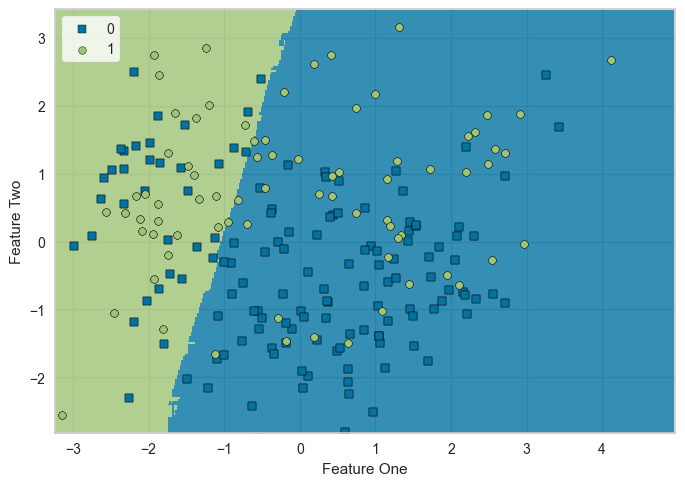

In [382]:
plot_model(voting_reg_final_fit,plot = 'boundary')

## Save Model

In [383]:
    
if "Bagging" in best_model_after_eval.loc[0,'Model']:
    
    model_folder = "models"
    os.makedirs(model_folder, exist_ok=True)  # Ensure the folder exists

    # Define the full file path
    model_file_path = os.path.join(model_folder, "Best_model_Classifier_bagging")
    save_model(best_model_final_fit,model_file_path)
    save_model(ensemble_bag_final_fit,model_file_path)
    explain_model = ensemble_bag
    explain_model_fit = ensemble_bag_final_fit
    
    assets_folder = "assets"
    os.makedirs(assets_folder, exist_ok=True)
    plot_model(ensemble_bag_final_fit,plot = 'confusion_matrix' , save = True)
    plot_model(ensemble_bag_final_fit,plot = 'boundary' , save = True)
    plot_model(ensemble_bag_final_fit,plot = 'class_report',save = True)
    #plot_model(ensemble_bag_final_fit,plot = 'feature' , save = True)
    shutil.move("Decision Boundary.png", os.path.join(assets_folder, "boundary_plot.png"))
    shutil.move("Confusion Matrix.png", os.path.join(assets_folder, "confusion_matrix_plot.png"))
    shutil.move("Class Report.png.png", os.path.join(assets_folder, "class_report_plot.png"))

    print("All plots successfully saved in the assets folder!")
    final_best_model = best_model_after_eval.iloc[0,0]
    
elif "Boosting" in best_model_after_eval.loc[0,'Model']:
    model_folder = "models"
    os.makedirs(model_folder, exist_ok=True)  # Ensure the folder exists

    # Define the full file path
    model_file_path = os.path.join(model_folder, "Best_Model_Classifier_Boosting")
    #save_model(best_model_final_fit,model_file_path)
    save_model(ensemble_boost_final_fit,model_file_path)
    explain_model = ensemble_boost
    explain_model_fit = ensemble_boost_final_fit
    assets_folder = "assets"
    os.makedirs(assets_folder, exist_ok=True)
    plot_model(ensemble_boost_final_fit,plot = 'boundary' , save = True)
    plot_model(ensemble_boost_final_fit,plot = 'confusion_matrix' , save = True)
    plot_model(ensemble_boost_final_fit,plot = 'class_report' , save = True)
    shutil.move("Decision Boundary.png", os.path.join(assets_folder, "boundary_plot.png"))
    shutil.move("Confusion Matrix.png", os.path.join(assets_folder, "confusion_matrix_plot.png"))
    shutil.move("Class Report.png", os.path.join(assets_folder, "class_report_plot.png"))

    print("All plots successfully saved in the assets folder!")
    final_best_model = best_model_after_eval.iloc[0,0]
    
elif "Voting" in best_model_after_eval.loc[0,'Model']:
    model_folder = "models"
    os.makedirs(model_folder, exist_ok=True)  # Ensure the folder exists

    # Define the full file path
    model_file_path = os.path.join(model_folder, "Best_Model_Classifier_Voting")
    
    save_model(voting_reg_final_fit,model_file_path)
    explain_model = voting_reg
    explain_model_fit = voting_reg_final_fit
    assets_folder = "assets"
    os.makedirs(assets_folder, exist_ok=True)
    plot_model(voting_reg_final_fit,plot = 'boundary' , save = True)
    plot_model(voting_reg_final_fit,plot = 'confusion_matrix' , save = True)
    plot_model(voting_reg_final_fit,plot = 'class_report' , save = True)
    shutil.move("Decision Boundary.png", os.path.join(assets_folder, "boundary_plot.png"))
    shutil.move("Confusion Matrix.png", os.path.join(assets_folder, "confusion_matrix_plot.png"))
    shutil.move("Class Report.png", os.path.join(assets_folder, "class_report_plot.png"))

    print("All plots successfully saved in the assets folder!")
    final_best_model = best_model_after_eval.iloc[0,0]
    
elif "Stacking" in best_model_after_eval.loc[0,'Model']:
    
    model_folder = "models"
    os.makedirs(model_folder, exist_ok=True)  # Ensure the folder exists

    # Define the full file path
    model_file_path = os.path.join(model_folder, "Best_Model_Classifier_Stack")
    save_model(stack_reg_final_fit,model_file_path)
    explain_model = stack_reg
    explain_model_fit = stack_reg_final_fit
    assets_folder = "assets"
    os.makedirs(assets_folder, exist_ok=True)
    plot_model(stack_reg_final_fit,plot = 'boundary' , save = True)
    plot_model(stack_reg_final_fit,plot = 'confusion_matrix' , save = True)
    plot_model(stack_reg_final_fit,plot = 'class_report' , save = True)
    shutil.move("Decision Boundary.png", os.path.join(assets_folder, "boundary_plot.png"))
    shutil.move("Confusion Matrix.png", os.path.join(assets_folder, "confusion_matrix_plot.png"))
    shutil.move("Class Report.png", os.path.join(assets_folder, "class_report_plot.png"))

    print("All plots successfully saved in the assets folder!")
    final_best_model = best_model_after_eval.iloc[0,0]
    
else:
    
     # Define the folder where the model should be saved
    model_folder = "models"
    os.makedirs(model_folder, exist_ok=True)  # Ensure the folder exists

    # Define the full file path
    model_file_path = os.path.join(model_folder, "Best_model_Classifier")
    save_model(best_model_final_fit,model_file_path)
    explain_model = tune_best_model_final
    explain_model_fit = best_model_final_fit
    
    assets_folder = "assets"
    os.makedirs(assets_folder, exist_ok=True)
    plot_model(best_model_final_fit,plot = 'boundary' , save = True)
    plot_model(best_model_final_fit,plot = 'confusion_matrix' , save = True)
    plot_model(best_model_final_fit,plot = 'class_report' , save = True)
    shutil.move("Decision Boundary.png", os.path.join(assets_folder, "boundary_plot.png"))
    shutil.move("Confusion Matrix.png", os.path.join(assets_folder, "confusion_matrix_plot.png"))
    shutil.move("Class Report.png", os.path.join(assets_folder, "class_report_plot.png"))

    print("All plots successfully saved in the assets folder!")
    final_best_model = best_model_after_eval.iloc[0,0]
    
    
    

Transformation Pipeline and Model Successfully Saved


All plots successfully saved in the assets folder!


In [384]:
plot_model(best_model_final_fit,plot = 'class_report',save = True)

'Class Report.png'

In [385]:
ml_model_report_inputs['final_best_model'] = final_best_model

In [386]:
assets_folder = "metadata"
os.makedirs(assets_folder, exist_ok=True)
json_file_path_ml_report = os.path.join(assets_folder, "ml_model_report_inputs.json")
with open(json_file_path_ml_report, 'w') as f:
    json.dump(ml_model_report_inputs, f,default=str)

In [387]:
ml_model_report_inputs

{'data_split': {'train_data_size': 510,
  'test_data_size': 220,
  'evaluation_data_size': 38},
 'total_preprocess_param_comb': 15,
 'intial_models_comparison': {'model': ['Ridge Classifier',
   'Logistic Regression',
   'Gradient Boosting Classifier',
   'Random Forest Classifier',
   'Ada Boost Classifier',
   'K Neighbors Classifier',
   'Decision Tree Classifier',
   'SVM - Linear Kernel'],
  'accuracy': [0.7549, 0.7686, 0.749, 0.7412, 0.7431, 0.6922, 0.6882, 0.5725],
  'auc': [0.8194, 0.8186, 0.8131, 0.7993, 0.7732, 0.6995, 0.6668, 0.5287],
  'recall': [0.5221, 0.5556, 0.5841, 0.5619, 0.5783, 0.4943, 0.5956, 0.393],
  'precision': [0.6973, 0.716, 0.6554, 0.6498, 0.6465, 0.5672, 0.5486, 0.3094],
  'f1': [0.5962, 0.6245, 0.6158, 0.5996, 0.6098, 0.5277, 0.5704, 0.2769]},
 'model_comparison': {'total_fits': 15,
  'top_model': 'Ridge Classifier',
  'top_param': {'Transformation': True,
   'Transform_Method': 'yeo-johnson',
   'Normalization': False,
   'Normalize_Method': None,
   'Out

## Explainable AI

## Global Explainability (Final)

In [388]:
import shap

In [389]:
# Ensure the assets folder exists
assets_folder = "assets"
os.makedirs(assets_folder, exist_ok=True)

sample = sample_reg

predict_fn = lambda x: explain_model.predict_proba(x)

# Create a KernelExplainer on the transformed data
explainer = shap.KernelExplainer(predict_fn, sample)

# Compute SHAP values
shap_values = explainer.shap_values(sample)

if isinstance(shap_values, list) and len(shap_values) > 1:
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values
    
# Plot the SHAP summary
shap.summary_plot(shap_values_to_plot, sample,plot_type='dot',show = False)

shap_plot_path = os.path.join(assets_folder, "shap_summary_plot_class.png")
plt.savefig(shap_plot_path, bbox_inches="tight")

# Close the plot to free memory
plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

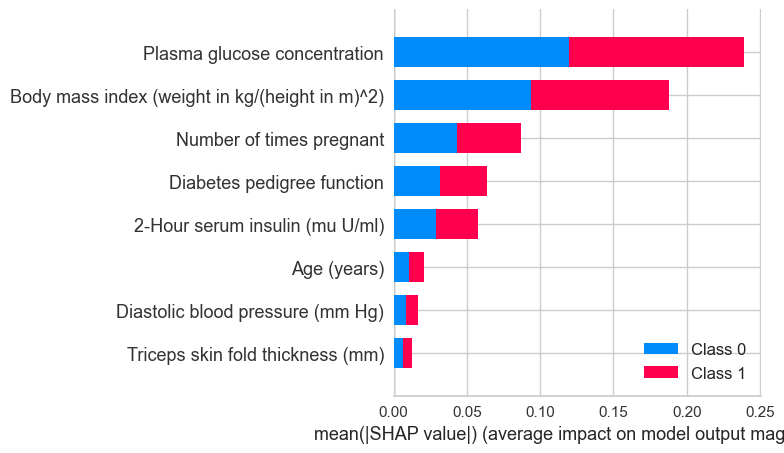

In [390]:
shap.summary_plot(shap_values,sample,plot_type='bar',show = False)
shap_plot_path = os.path.join(assets_folder, "shap_summary_plot_feature_class.png")
plt.savefig(shap_plot_path,)

In [391]:
sample.columns

Index(['Number of times pregnant', 'Plasma glucose concentration',
       'Diastolic blood pressure (mm Hg)', 'Triceps skin fold thickness (mm)',
       '2-Hour serum insulin (mu U/ml)',
       'Body mass index (weight in kg/(height in m)^2)',
       'Diabetes pedigree function', 'Age (years)'],
      dtype='object')

In [392]:
sample

,Number of times pregnant,Plasma glucose concentration,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years)
501,1.624648,98.807281,648.503099,11.278365,0.0000,90.859041,0.186524,0.892591
686,1.624648,155.901357,537.106267,0.000000,0.0000,49.225514,0.207867,0.885918
272,1.624648,145.893998,737.232686,0.000000,0.0000,48.952865,0.180179,0.899885
688,0.749627,168.450170,677.594606,9.857325,5.3118,51.971465,0.342168,0.887273
276,2.646038,125.971447,484.467346,9.354463,0.0000,58.701711,0.199976,0.893433
...,...,...,...,...,...,...,...,...
44,2.646038,192.404350,537.106267,0.000000,0.0000,61.274626,0.199078,0.899885
10,1.936385,130.939930,960.771573,0.000000,0.0000,92.123059,0.146323,0.894218
717,3.170953,111.118767,648.503099,7.732396,0.0000,49.225514,0.297648,0.904681
453,1.244988,142.148886,0.000000,0.000000,0.0000,39.903010,0.342783,0.907303


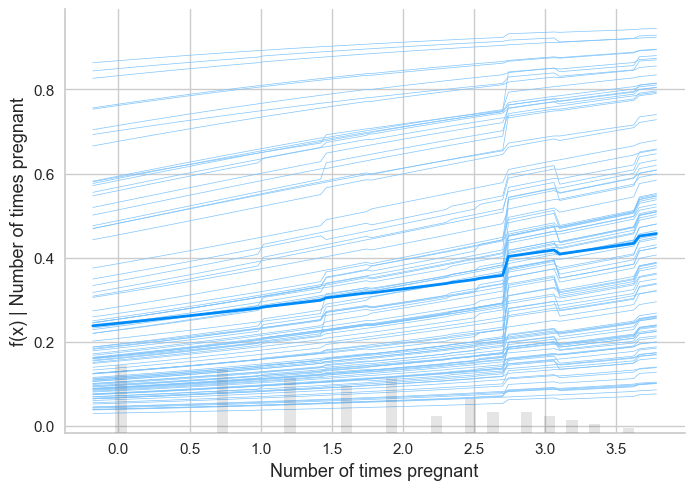

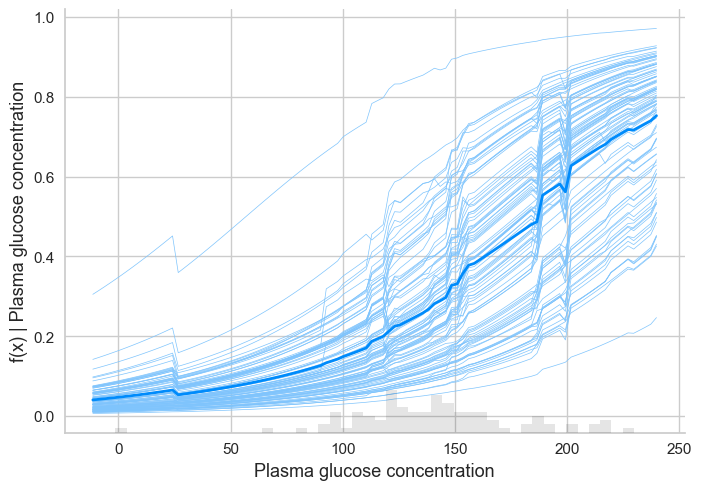

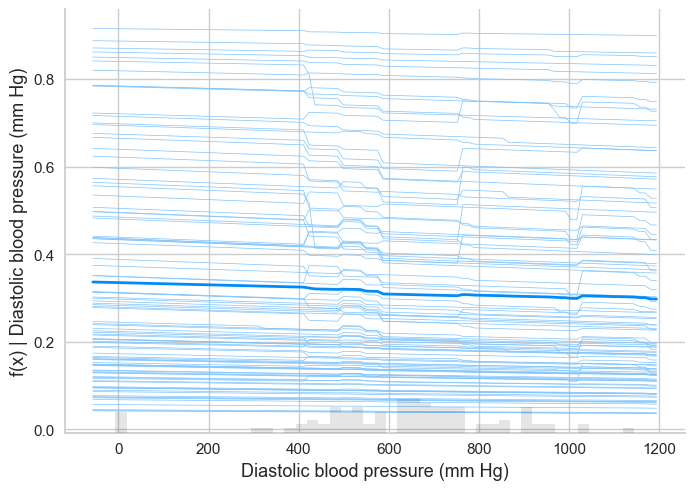

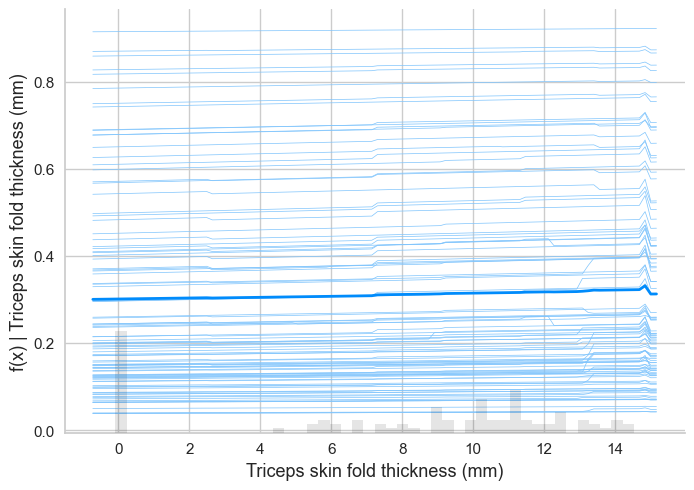

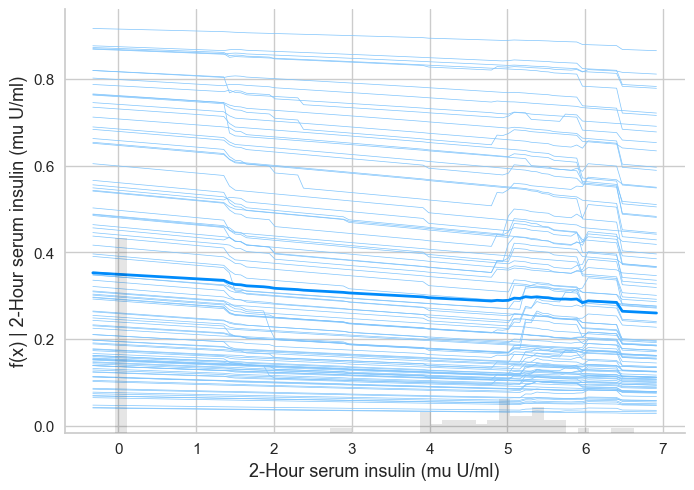

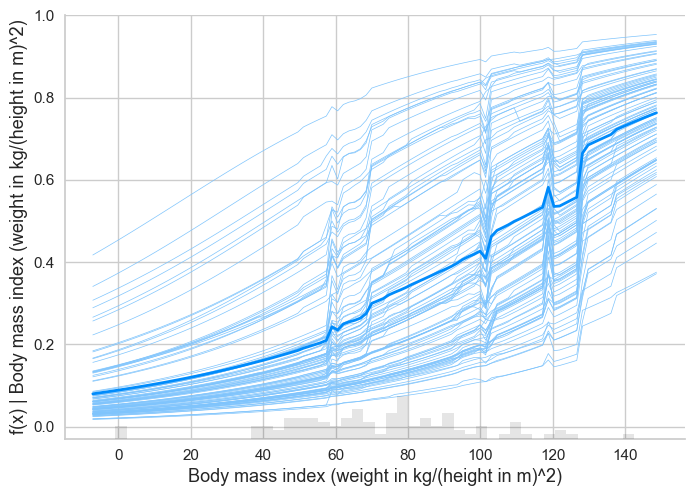

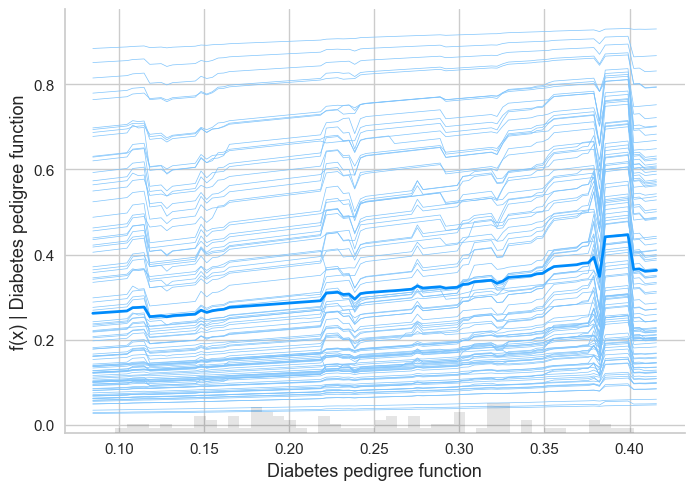

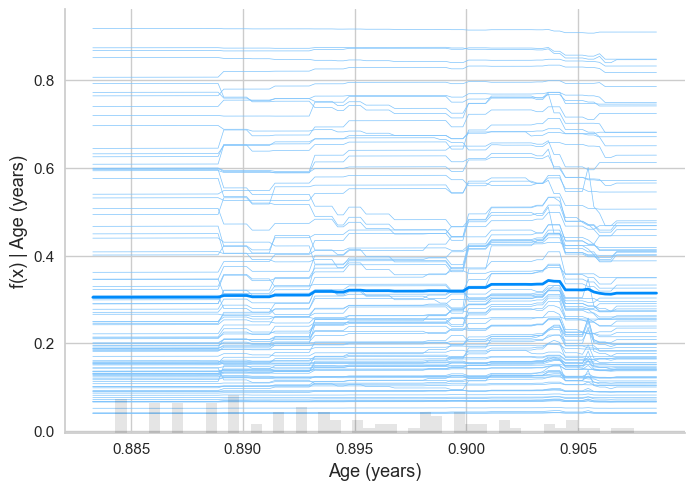

In [393]:
import re

def predict_positive(x):
    # Return probability for positive class (class 1)
    return explain_model.predict_proba(x)[:, 1]


for feature in sample.columns:
    
    shap.partial_dependence_plot(feature,predict_positive,sample,show=False)
    safe_fea = re.sub(r'[\\/*?:"<>|]', "", feature)
    name = f"shap_partial_class_{safe_fea}.png"
    shap_plot_path = os.path.join(assets_folder, name)
    plt.savefig(shap_plot_path, bbox_inches="tight")
    

## Local Explainability (Final)

pycaret interpret model only supports  lightgbm, dt, et, rf 

In [394]:
import os
import shap
import matplotlib.pyplot as plt
import numpy as np

# Ensure the assets folder exists
assets_folder = "assets"
os.makedirs(assets_folder, exist_ok=True)

# Use sample_reg as your sample data and assume explain_model is your trained model
predict_fn = lambda x: explain_model.predict_proba(x)

# Create a KernelExplainer on the sample data
explainer = shap.KernelExplainer(predict_fn, sample)

for i in range(5):
    test_instance = sample.sample(n=1)
    
    # Compute SHAP values for the test instance
    shap_values = explainer.shap_values(test_instance)
    
    # For binary classification, select the positive class (index 1)
    # and extract the first row to get a 1D array
    single_shap_values = shap_values[1][0]
    
    # Extract the corresponding data for the test instance
    single_test_instance = test_instance.iloc[0]
    
    # Get the base value for class 1 and ensure it's a scalar
    base_value = explainer.expected_value[1]
    if isinstance(base_value, np.ndarray):
        base_value = base_value.item()
    
    # Create an Explanation object
    exp_obj = shap.Explanation(
        values=single_shap_values,
        base_values=base_value,
        data=single_test_instance,
        feature_names=sample.columns
    )
    
    # Plot the waterfall plot for this single explanation
    fig, ax = plt.subplots(figsize=(8, 5))
    shap.waterfall_plot(exp_obj, show=False)
    
    # Save the plot
    name = f"shap_local_explain_sample_class{i}.png"
    shap_plot_path = os.path.join(assets_folder, name)
    plt.savefig(shap_plot_path, bbox_inches="tight")
    plt.close(fig)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [395]:
evaluate_model(best_model_final_fit)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### End of Code

In [396]:
ml_model_report_inputs

{'data_split': {'train_data_size': 510,
  'test_data_size': 220,
  'evaluation_data_size': 38},
 'total_preprocess_param_comb': 15,
 'intial_models_comparison': {'model': ['Ridge Classifier',
   'Logistic Regression',
   'Gradient Boosting Classifier',
   'Random Forest Classifier',
   'Ada Boost Classifier',
   'K Neighbors Classifier',
   'Decision Tree Classifier',
   'SVM - Linear Kernel'],
  'accuracy': [0.7549, 0.7686, 0.749, 0.7412, 0.7431, 0.6922, 0.6882, 0.5725],
  'auc': [0.8194, 0.8186, 0.8131, 0.7993, 0.7732, 0.6995, 0.6668, 0.5287],
  'recall': [0.5221, 0.5556, 0.5841, 0.5619, 0.5783, 0.4943, 0.5956, 0.393],
  'precision': [0.6973, 0.716, 0.6554, 0.6498, 0.6465, 0.5672, 0.5486, 0.3094],
  'f1': [0.5962, 0.6245, 0.6158, 0.5996, 0.6098, 0.5277, 0.5704, 0.2769]},
 'model_comparison': {'total_fits': 15,
  'top_model': 'Ridge Classifier',
  'top_param': {'Transformation': True,
   'Transform_Method': 'yeo-johnson',
   'Normalization': False,
   'Normalize_Method': None,
   'Out